In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [2]:
import matplotlib as mpl

In [3]:
from glob import glob

In [22]:
# download from https://drive.google.com/u/0/uc?id=1cGy4RNDV87ZHEXbiozABr9gsSrZpPaPz&export=download

In [26]:
!ls -l

total 1059652
-rw-r--r-- 1 ivan sudo    111888 Apr  1 09:04 KL_cyclostationary.ipynb
-rw-r--r-- 1 ivan sudo    119222 Apr  1 09:06 KL_text.ipynb
-rw-r--r-- 1 ivan sudo    491471 Apr  1 08:42 Semi_supervised_figures.ipynb
drwxrwxr-x 3 ivan sudo        34 Dec 26  2017 __MACOSX
-rw-r--r-- 1 ivan sudo     70661 Apr  1 08:42 all_scenario_events_per_client.ipynb
drwxr-xr-x 2 ivan sudo   1011712 Aug 18  2013 blogs
-rw-r--r-- 1 ivan sudo 632898892 Apr  1 09:09 blogs.zip
drwxr-xr-x 2 ivan sudo       112 Apr  1 09:03 figures
-rw-r--r-- 1 ivan sudo     12262 Apr  1 08:42 final_table_calculation.ipynb
-rw-r--r-- 1 ivan sudo    207963 Apr  1 08:42 hidden_size_figures.ipynb
-rw-r--r-- 1 ivan sudo     57365 Apr  1 08:42 prepare_figures.ipynb
-rw-r--r-- 1 ivan sudo    135412 Apr  1 08:42 tinkof_results.ipynb
-rw-r--r-- 1 ivan sudo    211462 Apr  1 08:42 tinkoff_als.ipynb
-rw-r--r-- 1 ivan sudo    179444 Apr  1 08:42 tinkoff_binary_classification_model.ipynb
-rw-r--r-- 1 ivan sudo    130155 Apr  1 08:4

In [25]:
!unzip -q blogs.zip

In [27]:
blogs = glob('blogs/*.xml')

In [28]:
blogs[0]

'blogs/1000331.female.37.indUnk.Leo.xml'

In [29]:
from tqdm.auto import tqdm

In [30]:
import re

In [31]:
blog_texts = blogs
blog_texts = [open(b, 'rb').read().decode('cp1252', errors='ignore') for b in tqdm(blog_texts)]
blog_texts = [re.sub(r'[\r\n]', ' ', b) for b in tqdm(blog_texts)]
blog_texts = [re.sub(r'</post>', '</post>\r\n', b) for b in tqdm(blog_texts)]
blog_texts = [re.findall(r'<post>(.*)</post>', b) for b in tqdm(blog_texts)]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

In [32]:
blog_texts = [p for b in tqdm(blog_texts) for p in b]

  0%|          | 0/19320 [00:00<?, ?it/s]

In [33]:
len(blog_texts)

681288

In [34]:
post_text = blog_texts
post_text = [re.sub(r'[^\w\s]', r'', p.lower()) for p in post_text]
post_text[0]

'    \t         well everyone got up and going this morning  its still raining but thats okay with me  sort of suits my mood  i could easily have stayed home in bed with my book and the cats  this has been a lot of rain though  people have wet basements there are lakes where there should be golf courses and fields everything is green green green  but it is supposed to be 26 degrees by friday so well be dealing with mosquitos next week  i heard winnipeg described as an old testament city on  urllink cbc radio one  last week and it sort of rings true  floods infestations etc etc                 '

In [35]:
post_text[0]

'    \t         well everyone got up and going this morning  its still raining but thats okay with me  sort of suits my mood  i could easily have stayed home in bed with my book and the cats  this has been a lot of rain though  people have wet basements there are lakes where there should be golf courses and fields everything is green green green  but it is supposed to be 26 degrees by friday so well be dealing with mosquitos next week  i heard winnipeg described as an old testament city on  urllink cbc radio one  last week and it sort of rings true  floods infestations etc etc                 '

In [36]:
post_words = post_text
post_words = [p.split() for p in post_words]
post_words = [[w.strip() for w in p] for p in post_words]
post_words = [[w for w in p if len(w) > 0] for p in post_words]
post_words[0]

['well',
 'everyone',
 'got',
 'up',
 'and',
 'going',
 'this',
 'morning',
 'its',
 'still',
 'raining',
 'but',
 'thats',
 'okay',
 'with',
 'me',
 'sort',
 'of',
 'suits',
 'my',
 'mood',
 'i',
 'could',
 'easily',
 'have',
 'stayed',
 'home',
 'in',
 'bed',
 'with',
 'my',
 'book',
 'and',
 'the',
 'cats',
 'this',
 'has',
 'been',
 'a',
 'lot',
 'of',
 'rain',
 'though',
 'people',
 'have',
 'wet',
 'basements',
 'there',
 'are',
 'lakes',
 'where',
 'there',
 'should',
 'be',
 'golf',
 'courses',
 'and',
 'fields',
 'everything',
 'is',
 'green',
 'green',
 'green',
 'but',
 'it',
 'is',
 'supposed',
 'to',
 'be',
 '26',
 'degrees',
 'by',
 'friday',
 'so',
 'well',
 'be',
 'dealing',
 'with',
 'mosquitos',
 'next',
 'week',
 'i',
 'heard',
 'winnipeg',
 'described',
 'as',
 'an',
 'old',
 'testament',
 'city',
 'on',
 'urllink',
 'cbc',
 'radio',
 'one',
 'last',
 'week',
 'and',
 'it',
 'sort',
 'of',
 'rings',
 'true',
 'floods',
 'infestations',
 'etc',
 'etc']

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
len(post_words)

681288

In [39]:
sum([len(p) for p in post_words])

135834590

In [40]:
cleaned_texts = [' '.join(p) for p in post_words]

In [41]:
cv = CountVectorizer(min_df=1500)
cv.fit(cleaned_texts)
len(cv.vocabulary_)

4650

In [42]:
cv.vocabulary_

{'well': 4489,
 'everyone': 1465,
 'got': 1824,
 'up': 4346,
 'and': 230,
 'going': 1811,
 'this': 4158,
 'morning': 2713,
 'its': 2215,
 'still': 3913,
 'raining': 3289,
 'but': 649,
 'thats': 4125,
 'okay': 2890,
 'with': 4552,
 'me': 2600,
 'sort': 3817,
 'of': 2871,
 'suits': 3993,
 'my': 2749,
 'mood': 2708,
 'could': 989,
 'easily': 1341,
 'have': 1932,
 'stayed': 3896,
 'home': 2021,
 'in': 2118,
 'bed': 445,
 'book': 554,
 'the': 4127,
 'cats': 718,
 'has': 1924,
 'been': 448,
 'lot': 2514,
 'rain': 3287,
 'though': 4163,
 'people': 3017,
 'wet': 4496,
 'there': 4138,
 'are': 293,
 'where': 4505,
 'should': 3685,
 'be': 428,
 'golf': 1814,
 'fields': 1595,
 'everything': 1467,
 'is': 2200,
 'green': 1853,
 'it': 2207,
 'supposed': 4010,
 'to': 4204,
 '26': 34,
 'degrees': 1140,
 'by': 655,
 'friday': 1715,
 'so': 3778,
 'dealing': 1110,
 'next': 2803,
 'week': 4481,
 'heard': 1946,
 'described': 1161,
 'as': 317,
 'an': 227,
 'old': 2892,
 'city': 819,
 'on': 2896,
 'urllink': 

In [43]:
vectorised_text = [
    [cv.vocabulary_.get(w, -1) for w in l] for l in tqdm(post_words)
]

  0%|          | 0/681288 [00:00<?, ?it/s]

In [44]:
import numpy as np

In [45]:
vectorised_text = [np.array(p) for p in vectorised_text]

In [46]:
vectorised_text[:5]

[array([4489, 1465, 1824, 4346,  230, 1811, 4158, 2713, 2215, 3913, 3289,
         649, 4125, 2890, 4552, 2600, 3817, 2871, 3993, 2749, 2708,   -1,
         989, 1341, 1932, 3896, 2021, 2118,  445, 4552, 2749,  554,  230,
        4127,  718, 4158, 1924,  448,   -1, 2514, 2871, 3287, 4163, 3017,
        1932, 4496,   -1, 4138,  293,   -1, 4505, 4138, 3685,  428, 1814,
          -1,  230, 1595, 1467, 2200, 1853, 1853, 1853,  649, 2207, 2200,
        4010, 4204,  428,   34, 1140,  655, 1715, 3778, 4489,  428, 1110,
        4552,   -1, 2803, 4481,   -1, 1946,   -1, 1161,  317,  227, 2892,
          -1,  819, 2896, 4360,   -1, 3285, 2898, 2370, 4481,  230, 2207,
        3817, 2871, 3461, 4278,   -1,   -1, 1451, 1451]),
 array([2749,   -1, 2892, 2796, 3923, 4057, 3659, 3542, 2696,  230, 4503,
          -1, 3542, 4625, 3659, 3542,   -1,   -1, 2886, 4617, 4505, 1247,
        2354,  628, 1983, 2118, 4127, 3287,  263, 4204, 1945, 1972, 2949,
        4412, 4389, 4389,   -1, 2844,   -1, 3391, 4158

In [47]:
import matplotlib.pyplot as plt

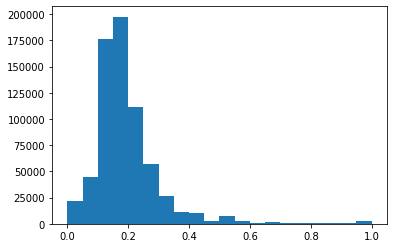

In [48]:
plt.hist([(p == -1).sum() / len(p) for p in vectorised_text if len(p) > 0], bins=20);

In [49]:
vectorised_text = [p[p >= 0] for p in vectorised_text]
vectorised_text = [p for p in vectorised_text if len(p > 0)]

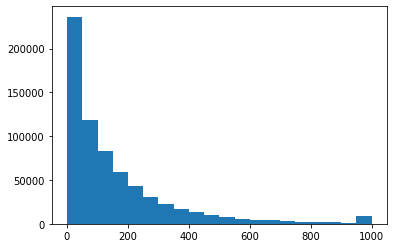

In [50]:
plt.hist(np.clip([len(p) for p in vectorised_text], None, 1000), bins=20);

In [51]:
vectorised_text = [p for p in vectorised_text if len(p) >= 100]

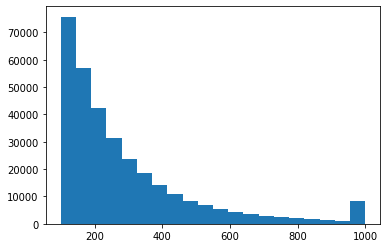

In [52]:
plt.hist(np.clip([len(p) for p in vectorised_text], None, 1000), bins=20);

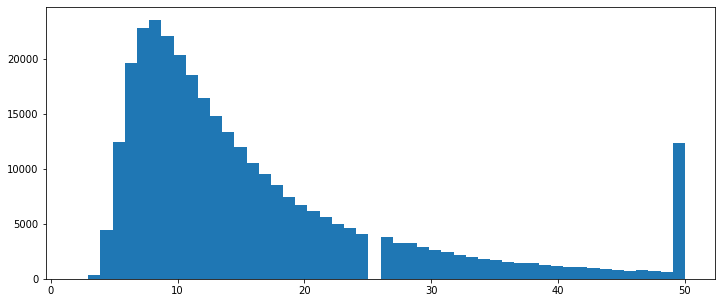

In [53]:
plt.figure(figsize=(12, 5))
plt.hist(np.clip([
    np.unique(p, return_counts=True)[1].max()
    for p in vectorised_text], 0, 50), bins=50);

In [54]:
cv_reverce_ix = {v: k for k, v in cv.vocabulary_.items()}

# KL text

In [55]:
min_len, max_len = 25, 150

In [56]:
seq_len_orig = np.array([len(p) for p in vectorised_text])
disjoint_split_point = np.where(
    seq_len_orig > 2 * min_len,
    (np.random.rand(len(seq_len_orig)) * (seq_len_orig - 2 * min_len)).astype(int) + min_len,
    (seq_len_orig / 2).astype(int),
)
seq_a = [p[:s] for p, s in zip(vectorised_text, disjoint_split_point)]
seq_b = [p[s:] for p, s in zip(vectorised_text, disjoint_split_point)]

In [57]:
def get_slice(seq):
    seq_len_orig = np.array([len(p) for p in seq])
    s_max_sample_len = np.clip(seq_len_orig.clip(0, max_len) - min_len, 0, None)
    s_len = (s_max_sample_len * np.random.rand(len(seq_len_orig))).astype(int) + min_len
    s_avl_pos = np.clip(seq_len_orig - s_len, 0, None)
    s_start = (s_avl_pos * np.random.rand(len(seq_len_orig))).astype(int)

    return [p[s: s + l] for p, s, l in zip(seq, s_start, s_len)]

In [58]:
' '.join([cv_reverce_ix.get(i) for i in seq_a[0]]), ' '.join([cv_reverce_ix.get(i) for i in seq_b[0]])

('oh which just reminded me we were talking about food at coffee break this morning is this becoming lost art are there any people under 40 who know how to do this those of us at coffee that fall in that age range couldnt what would happen if the world as',
 'we know it to exist la urllink day after tomorrow which is only being released today and cant wait to see love good picture with lots of special effects and we had to our food somehow well we in canada definitely would need to our food found lots of sites on including urllink this one but guess that wouldnt help me much if everything went better print it out and keep it just in case')

In [59]:
seq_a = get_slice(seq_a)
seq_b = get_slice(seq_b)

In [60]:
' '.join([cv_reverce_ix.get(i) for i in seq_a[0]]), ' '.join([cv_reverce_ix.get(i) for i in seq_b[0]])

('reminded me we were talking about food at coffee break this morning is this becoming lost art are there any people under 40 who know how to do this those of us at',
 'it to exist la urllink day after tomorrow which is only being released today and cant wait to see love good picture with lots of special effects and we had to our food somehow well we in canada definitely would need to our food found lots of sites on including urllink this one but guess that wouldnt help me much if everything went better print it out and keep it just in')

In [61]:
def _kl(a, b, verbose=False):
    a = {k: v / len(a) for k, v in zip(*np.unique(a, return_counts=True))}
    b = {k: v / len(b) for k, v in zip(*np.unique(b, return_counts=True))}

    d = {k: 0.0 if a.get(k, 0.0) == 0.0 else a.get(k, 0.0) * np.log(a.get(k, 1e-12) / b.get(k, 1e-12))
         for k in set(a.keys()).union(b.keys())}
    if verbose:
        print(sorted([(k, v) for k, v in d.items()], key=lambda x: -x[1]))
        
    return sum(d.values())


def kl_distribution(l_a, l_b):        
    return np.array([_kl(a, b) for a, b in tqdm(zip(l_a, l_b))])

In [62]:
import seaborn as sns

In [63]:
kl_pos = kl_distribution(seq_a, seq_b)

0it [00:00, ?it/s]

In [64]:
ix_shuffle = np.random.choice(len(seq_a), len(seq_a), replace=False)
kl_neg = kl_distribution(seq_a, [seq_b[i] for i in ix_shuffle])

0it [00:00, ?it/s]

In [65]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [67]:
df = pd.concat([
        pd.DataFrame({'KL': kl_pos.clip(0, None),
                      'type': 'Same post sample'}),
        pd.DataFrame({'KL': kl_neg.clip(0, None), 
                      'type': 'Random post sample'}),
    ], axis=0).reset_index(drop=True)

In [68]:
len(df)

645090

In [76]:
df.sample(frac=0.1).to_parquet('figures/kl_dis_text.parquet')

In [77]:
!ls -lh figures/kl_dis_text.parquet

-rw-r--r-- 1 ivan sudo 1.1M Apr  1 09:25 figures/kl_dis_text.parquet


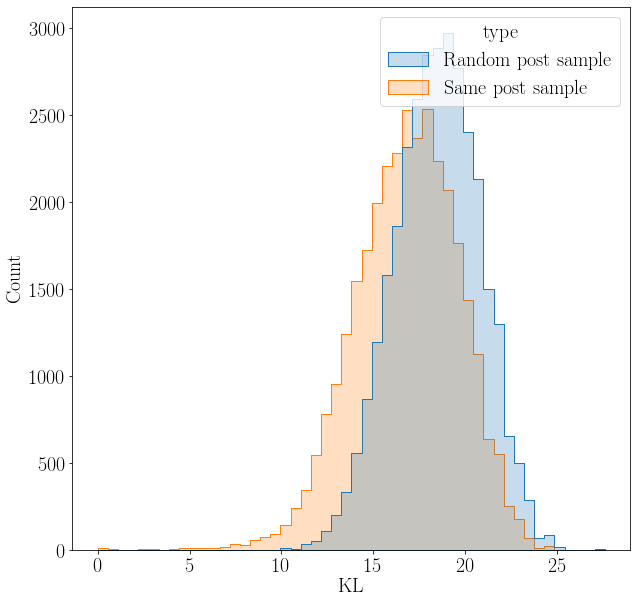

In [78]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10, 10))
    mpl.rc('font', size=20)

    sns.histplot(pd.read_parquet('figures/kl_dis_text.parquet'), x="KL", hue="type", bins=50, element='step')

    # plt.title('Age group')
    mpl.pyplot.savefig('figures/kl_dis_text.pdf', format='pdf', bbox_inches='tight')
    # plt.show()